In [26]:
%matplotlib inline

In [2]:
import nibabel as nib
import numpy as np
from nilearn.plotting import plot_img

In [3]:
!ls data/1005-faceperception/sub-sid000050/{anat,dwi}

data/1005-faceperception/sub-sid000050/anat:
sub-sid000050_acq-MPRAGE_T1w.json   sub-sid000050_acq-MPRAGE_T1w.nii.gz

data/1005-faceperception/sub-sid000050/dwi:
sub-sid000050_acq-30_run-10_dwi.bval   sub-sid000050_acq-30_run-11_dwi.bval
sub-sid000050_acq-30_run-10_dwi.bvec   sub-sid000050_acq-30_run-11_dwi.bvec
sub-sid000050_acq-30_run-10_dwi.json   sub-sid000050_acq-30_run-11_dwi.json
sub-sid000050_acq-30_run-10_dwi.nii.gz sub-sid000050_acq-30_run-11_dwi.nii.gz


With DWI (Diffusion Weighted Imaging) data, we have three filetypes:

1. \*.nii.gz: nifti files with acquired data
2. \*.bval: *b* values
3. \*.bvec: vectors associated to *b* values

In [4]:
dwi_fn = 'data/1005-faceperception/sub-sid000050/dwi/sub-sid000050_acq-30_run-10_dwi.nii.gz'
bval_fn = dwi_fn.replace('nii.gz', 'bval')
bvec_fn = dwi_fn.replace('nii.gz', 'bvec')
dwi = nib.load(dwi_fn)

In [5]:
dwi_d = dwi.get_data()
dwi_h = dwi.header

In [6]:
print(dwi_d.shape)

(128, 128, 70, 31)


In [7]:
print(dwi_h.get_zooms()[:-1])

(1.875, 1.875, 1.9999967)


- The DWI data that Jessi acquired is a 4D tensor (similar to fMRI)
- The 4th dimension represents the direction of the gradient (in the bvec file) with the respective b-value

In [8]:
bval = np.loadtxt(bval_fn)
bvec = np.loadtxt(bvec_fn)

In [9]:
print(bval[:10, None])

[[    0.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]]


In [10]:
print(bvec.T[:10])

[[ 0.         0.         0.       ]
 [-0.269953   0.458588  -0.846653 ]
 [ 0.13096    0.462918  -0.876674 ]
 [ 0.332891   0.118194  -0.935529 ]
 [-0.452529   0.686755  -0.568845 ]
 [-0.234698   0.918633  -0.317851 ]
 [-0.864114   0.502153  -0.0339114]
 [-0.768007   0.479918  -0.424081 ]
 [-0.471661   0.111902  -0.874651 ]
 [-0.778626   0.123807  -0.615154 ]]


In [11]:
print(len(bval), len(bvec.T))

31 31


This sequence had 30 directions with constant $b$-value: 1000

We can visualize the directions on a sphere, with center the center of the magnet

<IPython.core.display.Javascript object>


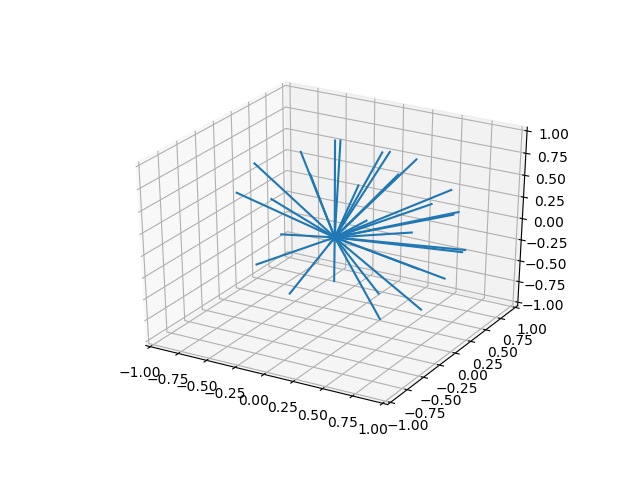

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for x, y, z in bvec.T:
    ax.plot_wireframe([0, x], [0, y], [0, z])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1);

OK, now we can start analyzing our data. First, let's visualize it.

<IPython.core.display.Javascript object>


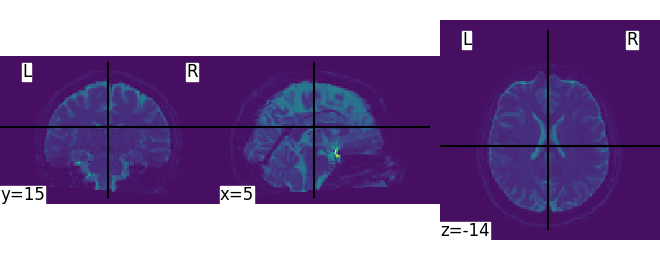

/Users/contematto/anaconda2/envs/dipy/lib/python3.6/site-packages/nilearn/image/resampling.py:472: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [14]:
plot_img(nib.Nifti1Image(dwi_d[:, :, :, 0], affine=dwi.affine))

<IPython.core.display.Javascript object>


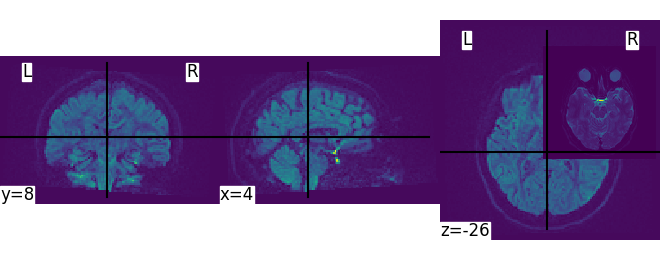

/Users/contematto/anaconda2/envs/dipy/lib/python3.6/site-packages/nilearn/image/resampling.py:472: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [15]:
plot_img(nib.Nifti1Image(dwi_d[:, :, :, 5], affine=dwi.affine))

In [19]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(bval_fn, bvec_fn)

from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [20]:
print(gtab.info)

B-values shape (31,)
         min 0.000000 
         max 1000.000000 
B-vectors shape (31, 3)
         min -0.970987 
         max 0.982276 
None


Steps

1. Preprocessing
    - Skull stripping
    - Alignment: b0 image to anatomical
2. Model
3. Visualize

In [21]:
from dipy.segment.mask import median_otsu

In [22]:
data_b0 = dwi_d[:, :, :, 0].squeeze()

In [23]:
data_b0.shape

(128, 128, 70)

In [38]:
data_b0.min(), data_b0.max()

(0, 3103)

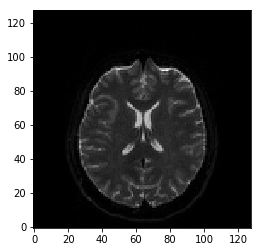

In [32]:
plt.imshow(data_b0[:, :, 35].T, origin='lower', cmap='gray')

In [36]:
b0_mask, mask = median_otsu(data_b0, 2, 1)

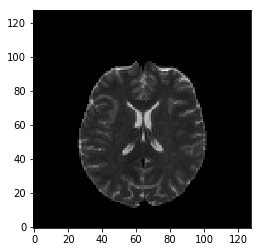

In [37]:
plt.imshow(b0_mask[:, :, 35].T, origin='lower', cmap='gray')